In [2]:
import os
import pickle

PROJECT_DIR="."
CHAPTER_ID="Visualizations"
IMAGES_PATH= os.path.join(PROJECT_DIR, "Images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path=os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print(f" Figure '{fig_id}' Saved.")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set();


from xgboost import XGBClassifier
import lightgbm as gbm

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report



In [ ]:
train=pd.read_csv('Datasets/train.csv', encoding='iso-8859-1', on_bad_lines='skip')
test=pd.read_csv('Datasets/Test.csv', encoding='iso-8859-1', on_bad_lines='skip')

In [ ]:
print(f"The shape of the train data: {train.shape}\nThe shape of the test data: {test.shape}")

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
train.describe().T

In [ ]:
test.describe().T

In [ ]:
train.isna().sum()

In [ ]:
test.isna().sum()

In [ ]:
train['Tour_ID'].isin( test['Tour_ID']).sum()

### EDA
- From here on, I'll be using only the `train` dataset, the test dataset is reserved for the final validation purposes.

In [ ]:
#Distribution of the target class.
sns.set(style="white", color_codes=True)

ax=sns.catplot(x="cost_category", data=train, kind="count")
plt.title("Cost Category Distribution")
plt.xlabel("Cost Category", weight="bold", size=14)
plt.ylabel("Head Count", weight="bold", size=14)
ax.set_xticklabels(rotation=90)
save_fig("Cost_Category_Dist", tight_layout=True)
plt.show()

In [ ]:
sns.set(style="white", color_codes=True)

ax =sns.catplot(x="cost_category", data=train, kind="count", hue="age_group")
plt.title("Cost Category by Age group", weight="bold")
plt.xlabel("Cost Category", size=14, weight="bold")
plt.ylabel("Head Count", weight="bold", size=14)
ax.set_xticklabels(rotation=75)
save_fig("Cost category by Age group", tight_layout=True)
plt.show();

In [ ]:
sns.set(style="white", color_codes=True)

ax =sns.catplot(x="cost_category", data=train, kind="count", hue="travel_with", aspect=2.0, legend_out=False)
plt.title("Cost Category Travel With", weight="bold")
plt.xlabel("Cost Category", size=14, weight="bold")
plt.ylabel("Head Count", weight="bold", size=14)
ax.set_xticklabels(rotation=75)
plt.legend(loc="upper right")
save_fig("Cost category by Travel With", tight_layout=True)
plt.show();

In [ ]:
train['total_people']=train["total_female"]+ train["total_male"]
bins=[0,5,20,100]
labels=["0-5", "6-20", '21+']

train['group_size']=pd.cut(train['total_people'], bins=bins, labels=labels)

sns.set(style="white", color_codes=True)

ax =sns.catplot(x="cost_category", data=train, kind="count", hue="group_size")
plt.title("Cost Category by Group Size", weight="bold")
plt.xlabel("Cost Category", size=14, weight="bold")
plt.ylabel("Head Count", weight="bold", size=14)
ax.set_xticklabels(rotation=75)
save_fig("Cost category by group size", tight_layout=True)
plt.show();

In [ ]:
print(f"{train.group_size.value_counts()}\n\nMaximum number of people in one travel group: {train.total_people.max()}\n\nFrequent number of people in one travel group: {train.total_people.mode()}")

In [ ]:
sns.set(style="white", color_codes=True)

ax =sns.catplot(x="cost_category", data=train, kind="count", hue="first_trip_tz")
plt.title("Cost Category by First Trip in TZ", weight="bold")
plt.xlabel("Cost Category", size=14, weight="bold")
plt.ylabel("Head Count", weight="bold", size=14)
ax.set_xticklabels(rotation=75)
save_fig("Cost category by first trip to TZ", tight_layout=True)
plt.show();

In [ ]:
sns.set(style="white", color_codes=True)

ax =sns.catplot(x="info_source", data=train, kind="count", hue="first_trip_tz", legend_out=False)
plt.title("Relationship between Information Source and First Trip TZ", weight="bold")
plt.xlabel("Source of Information", size=14, weight="bold")
plt.ylabel("Head Count", weight="bold", size=14)
ax.set_xticklabels(rotation=90)
#plt.legend(loc="upper right")
save_fig("Info Source vs First Trip Tz", tight_layout=True)
plt.show();

 Figure 'Cost category by Info Source' Saved.


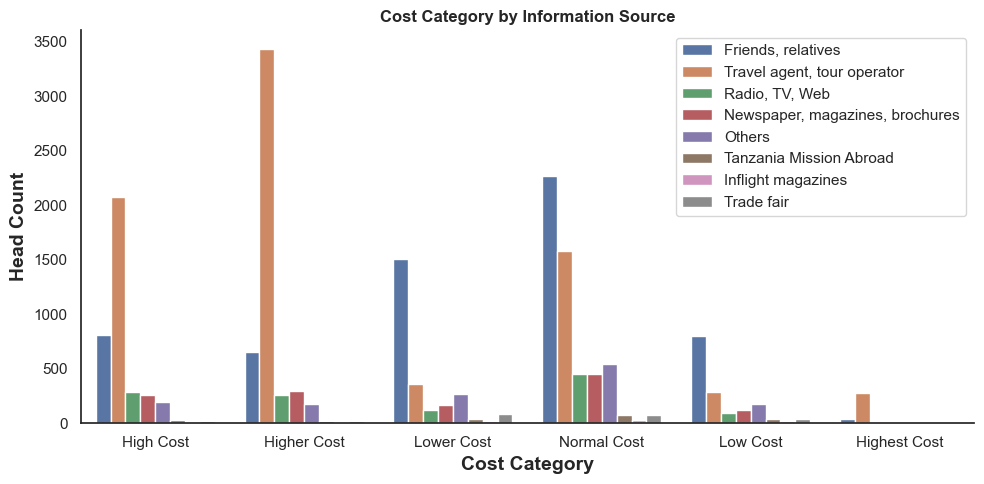

In [22]:
sns.set(style="white", color_codes=True)

ax =sns.catplot(x="cost_category", data=train, kind="count", hue="info_source", aspect=2.0, legend_out=False)
plt.title("Cost Category by Information Source", weight="bold")
plt.xlabel("Cost Category", size=14, weight="bold")
plt.ylabel("Head Count", weight="bold", size=14)
ax.set_xticklabels(rotation=0)
plt.legend(loc="upper right")
save_fig("Cost category by Info Source", tight_layout=True)
plt.show();

In [1]:
def plot_categorical(data, x, y, title=None, xlabel=None, ylabel=None):
    ct=pd.crosstab(data[x], data[y])
    
    fig, axes=plt.subplots(nrows=1,ncols=2, figsize=(12,8))
    
    sns.heatmap(ct, cmap='viridis', annot=True, cbar=False, fmt='g', ax=axes[0])
    axes[0].set_title('Heatmap' if title is None else title)
    axes[0].set_xlabel('' if xlabel is None else xlabel)
    axes[0].set_ylabel('' if ylabel is None else ylabel)
    
    #stacked_data = ct.apply(lambda x: x / x.sum(), axis=1)
    ct.plot(kind='bar', stacked=True, ax=axes[1])
    axes[1].set_title('Bar Chart' if title is None else title)
    axes[1].set_xlabel('' if xlabel is None else xlabel)
    axes[1].set_ylabel('' if ylabel is None else ylabel)
    axes[1].legend(title=y)
    
    """
    for patch in axes[1].patches:
        x, y = patch.get_xy()
        width, height = patch.get_width(), patch.get_height()
        axes[1].text(x + width/2, y + height/2, f'{height:.0%}', ha='center', va='center')
    
    """
    
    fig.suptitle(f"Relationship between {x} and {y}", fontsize=16, weight='bold')
    

In [ ]:
plot_categorical(train, "info_source", "cost_category")
save_fig("Cost Category and Info Source")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_13752\1649100835.py", line 1, in <module>
    plot_categorical(train, "info_source", "cost_category")
  File "C:\Users\User\AppData\Local\Temp\ipykernel_13752\1180061305.py", line 2, in plot_categorical
    ct=pd.crosstab(data[x], data[y])
  File "C:\Users\User\anaconda3\lib\site-packages\pandas\core\reshape\pivot.py", line 636, in crosstab
    if not is_nested_list_like(columns):
  File "C:\Users\User\anaconda3\lib\site-packages\pandas\core\dtypes\inference.py", line 258, in is_nested_list_like
    and all(is_list_like(item) for item in obj)
  File "C:\Users\User\anaconda3\lib\site-packages\pandas\core\base.py", line 761, in __iter__
    return map(self._values.item, range(self._values.size))
KeyboardInterrupt

During handling of the above e

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_13752\1649100835.py", line 1, in <module>
    plot_categorical(train, "info_source", "cost_category")
  File "C:\Users\User\AppData\Local\Temp\ipykernel_13752\1180061305.py", line 2, in plot_categorical
    ct=pd.crosstab(data[x], data[y])
  File "C:\Users\User\anaconda3\lib\site-packages\pandas\core\reshape\pivot.py", line 636, in crosstab
    if not is_nested_list_like(columns):
  File "C:\Users\User\anaconda3\lib\site-packages\pandas\core\dtypes\inference.py", line 258, in is_nested_list_like
    and all(is_list_like(item) for item in obj)
  File "C:\Users\User\anaconda3\lib\site-packages\pandas\core\base.py", line 761, in __iter__
    return map(self._values.item, range(self._values.size))
KeyboardInterrupt

During handling of the above e

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_13752\1649100835.py", line 1, in <module>
    plot_categorical(train, "info_source", "cost_category")
  File "C:\Users\User\AppData\Local\Temp\ipykernel_13752\1180061305.py", line 2, in plot_categorical
    ct=pd.crosstab(data[x], data[y])
  File "C:\Users\User\anaconda3\lib\site-packages\pandas\core\reshape\pivot.py", line 636, in crosstab
    if not is_nested_list_like(columns):
  File "C:\Users\User\anaconda3\lib\site-packages\pandas\core\dtypes\inference.py", line 258, in is_nested_list_like
    and all(is_list_like(item) for item in obj)
  File "C:\Users\User\anaconda3\lib\site-packages\pandas\core\base.py", line 761, in __iter__
    return map(self._values.item, range(self._values.size))
KeyboardInterrupt

During handling of the above e

 Figure 'Relationship between Cost category and Information source' Saved.


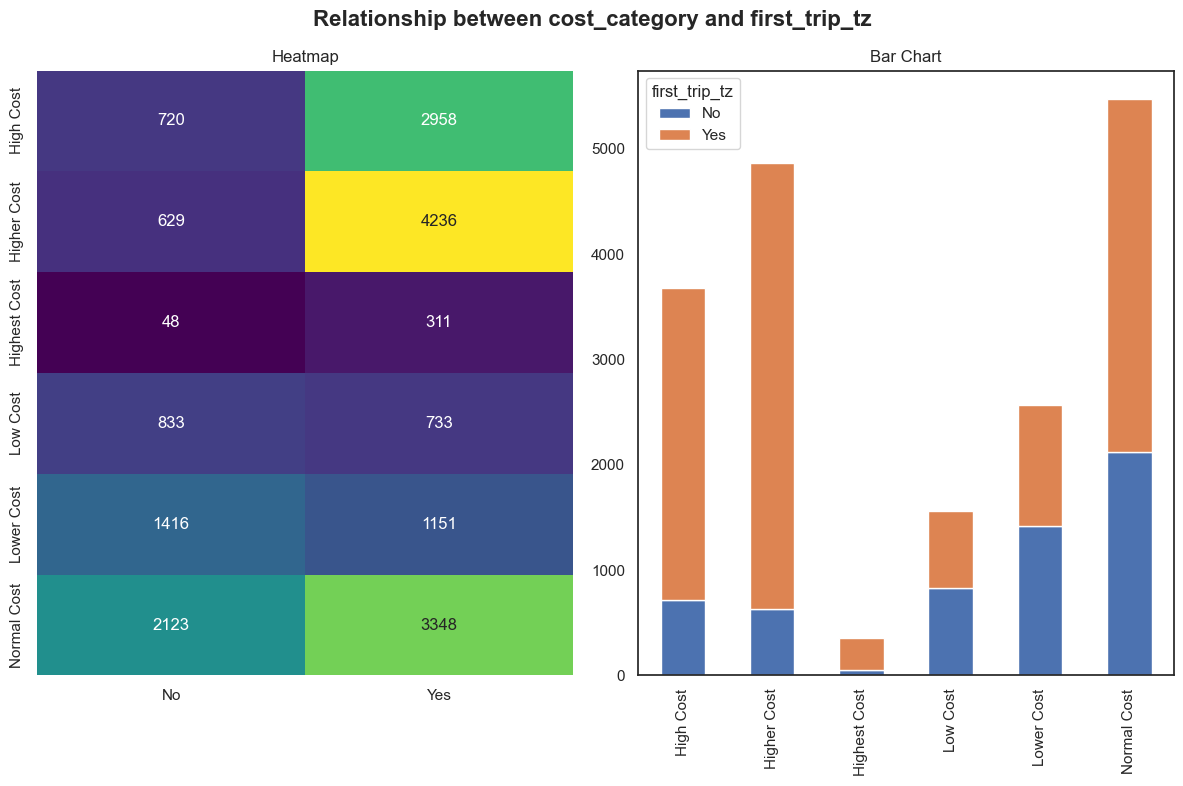

In [50]:
plot_categorical(train, "cost_category", "first_trip_tz")
save_fig("Relationship between Cost category and Information source")

In [ ]:
plot_categorical(train, "cost_category", "purpose")

<AxesSubplot: xlabel='first_trip_tz', ylabel='cost_category'>

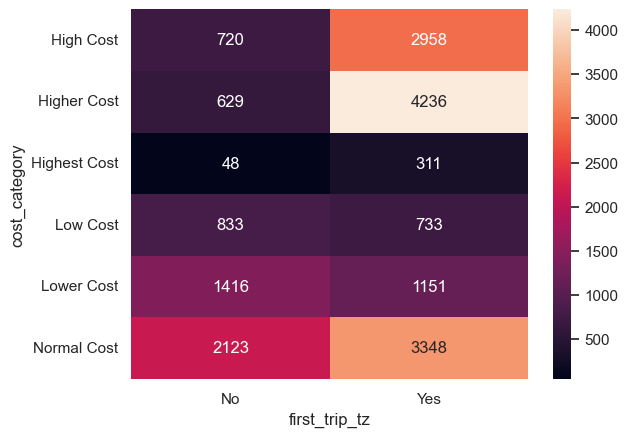

In [81]:
ct=pd.crosstab(train["cost_category"], train["first_trip_tz"])
sns.heatmap(ct, annot=True, fmt='g')

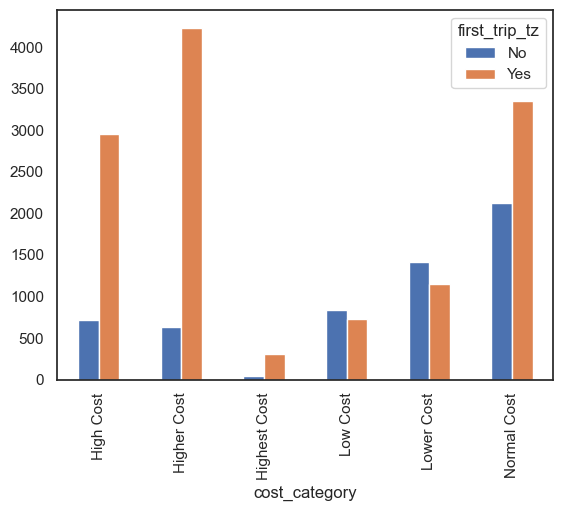

In [83]:
ct.plot(kind="bar", stacked=False);

In [68]:
train.columns

Index(['Tour_ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'first_trip_tz', 'cost_category', 'group_size',
       'total_people'],
      dtype='object')

In [17]:
df.total_male.value_counts()[:5]

1.0    15772
0.0     5737
2.0     2036
3.0      658
4.0      193
5.0       95
Name: total_male, dtype: int64

In [18]:
df.total_female.value_counts()[:5]

1.0    12854
0.0     8226
2.0     2325
3.0      690
4.0      269
5.0      111
Name: total_female, dtype: int64

In [19]:
missing=df.isnull().sum()*100/len(df)
missing_df=pd.DataFrame({"columns":df.columns,
                         "percentage missing": missing})
missing_df.reset_index(drop=True, inplace=True)
missing_df

,columns,percentage missing
0,Tour_ID,0.000000
1,country,0.000000
2,age_group,0.000000
3,travel_with,5.819656
4,total_female,0.016211
5,total_male,0.028369
6,purpose,0.000000
7,main_activity,0.000000
8,info_source,0.000000
9,tour_arrangement,0.000000


- fill the missing values

In [20]:
from sklearn.impute import KNNImputer

imputer=KNNImputer(n_neighbors=5)
#numerical columns
df[['total_female', 'total_male']]=imputer.fit_transform(df[['total_female','total_male']])

#categorical column
df['travel_with'].fillna(df['travel_with'].mode()[0], inplace=True)

In [21]:
df.isnull().sum()

Tour_ID                     0
country                     0
age_group                   0
travel_with                 0
total_female                0
total_male                  0
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
first_trip_tz               0
cost_category            6169
dtype: int64

In [22]:
cat_cols=[col for col in train.select_dtypes('object').columns]
num_cols=[col for col in df.select_dtypes(['int64','float'])]

In [24]:
print(f"Category Columns: {cat_cols}\nNumerical Columns: {num_cols}")

Category Columns: ['Tour_ID', 'country', 'age_group', 'travel_with', 'purpose', 'main_activity', 'info_source', 'tour_arrangement', 'package_transport_int', 'package_accomodation', 'package_food', 'package_transport_tz', 'package_sightseeing', 'package_guided_tour', 'package_insurance', 'first_trip_tz', 'cost_category']
Numerical Columns: ['total_female', 'total_male', 'night_mainland', 'night_zanzibar']


## EDA

In [26]:
def eda(plot):
    for col in cat_cols:
        return col.value_counts()
        

- Visualize the target class

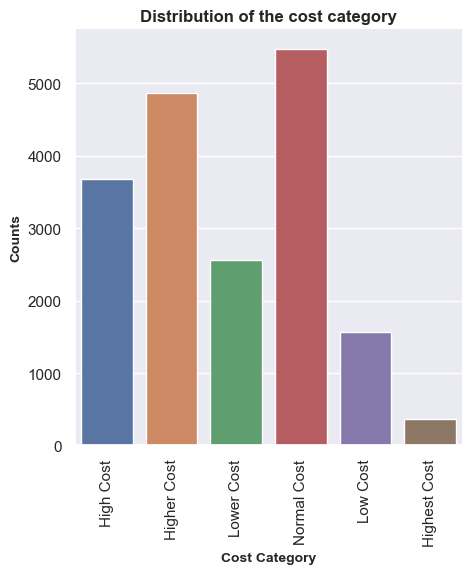

In [30]:
sns.axes_style(style="white")
ax=sns.catplot('cost_category', data=df, kind='count', legend=False)
plt.xlabel("Cost Category", size=10, weight="bold")
plt.ylabel("Counts", size=10, weight="bold")
plt.title("Distribution of the cost category", weight="bold")
ax.set_xticklabels( rotation=90)
plt.show();

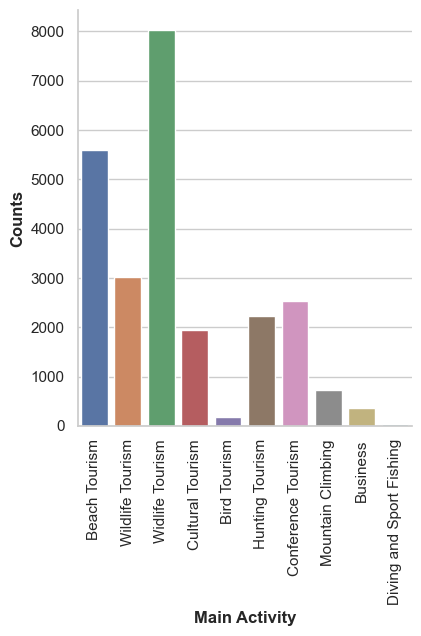

In [40]:
sns.set(style="whitegrid", color_codes=True)
sns.catplot('main_activity', data=df, kind='count')
plt.xlabel("Main Activity", weight="bold")
plt.ylabel("Counts", weight="bold")
plt.xticks(rotation=90)
plt.show();

In [46]:
df['main_activity']=df['main_activity'].replace('Widlife Tourism','Wildlife Tourism')

In [47]:
df.main_activity.value_counts()

Wildlife Tourism            11050
Beach Tourism                5604
Conference Tourism           2532
Hunting Tourism              2235
Cultural Tourism             1939
Mountain Climbing             727
Business                      370
Bird Tourism                  178
Diving and Sport Fishing       40
Name: main_activity, dtype: int64

In [49]:
data=df.groupby('main_activity').sum().reset_index()

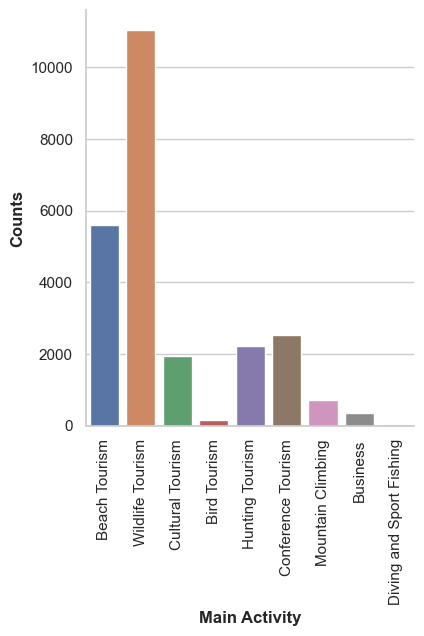

In [51]:
sns.set(style="whitegrid", color_codes=True)
sns.catplot('main_activity', data=df, kind='count')
plt.xlabel("Main Activity", weight="bold")
plt.ylabel("Counts", weight="bold")
plt.xticks(rotation=90)
plt.show()


### Building the models

In [ ]:
train=df(:,18506)
test=

In [54]:
train.shape, test.shape

((18506, 21), (6169, 20))

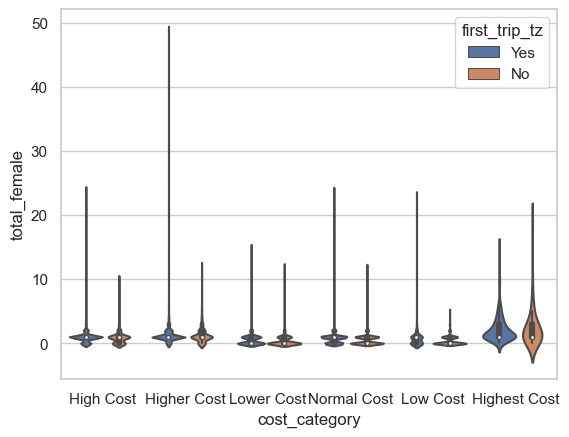

In [55]:
sns.violinplot(x='cost_category', y='total_female', hue='first_trip_tz', data=df);

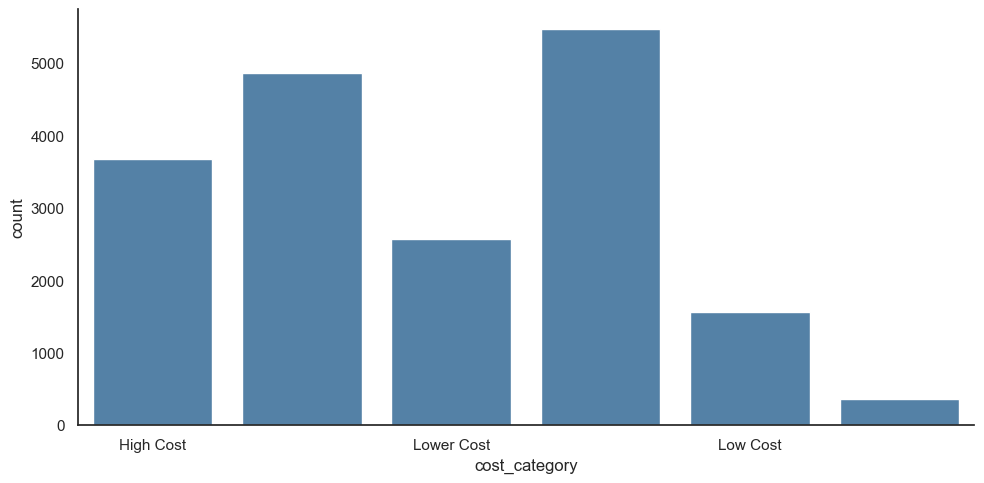

In [56]:
with sns.axes_style('white'):
    g=sns.catplot(x='cost_category', data=train,aspect=2,
                  kind='count',color='steelblue')
    g.set_xticklabels(step=2);

In [ ]:
y=train.cost_category.value_counts()

In [ ]:
sns.pairplot(train, hue='first_trip_tz', height=3.0);

In [15]:
data=train.groupby('cost_category')['country'].describe()

In [16]:
data

,count,unique,top,freq
cost_category,,,,
High Cost,3678,94,ITALY,733
Higher Cost,4865,90,UNITED STATES OF AMERICA,1320
Highest Cost,359,37,UNITED STATES OF AMERICA,79
Low Cost,1566,83,KENYA,175
Lower Cost,2567,86,UGANDA,367
Normal Cost,5471,119,UNITED KINGDOM,850


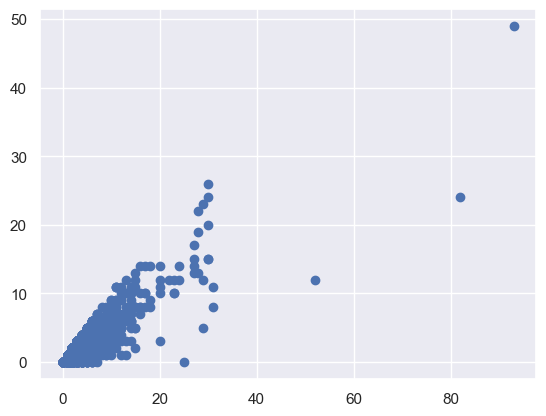

In [17]:
plt.scatter(train.total_people,train.total_female);

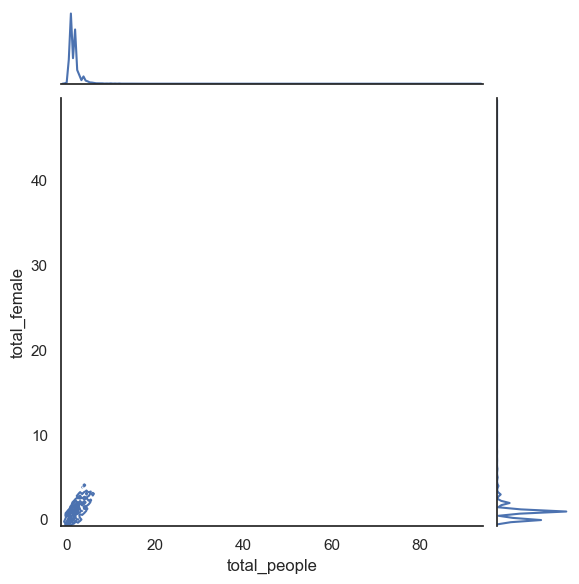

In [18]:
with sns.axes_style('white'):
    sns.jointplot(x=train.total_people, y=train.total_female, data=train, kind='kde');

In [19]:
test=pd.read_csv('Test.csv')

In [20]:
test.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz
0,tour_idynufedne,KOREA,25-44,Alone,0.0,1.0,Leisure and Holidays,Widlife Tourism,Others,Independent,No,No,No,No,No,No,No,7,4,Yes
1,tour_id9r3y5moe,UNITED KINGDOM,45-64,With Children,1.0,1.0,Leisure and Holidays,Conference Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,Yes,7,0,Yes
2,tour_idf6itml6g,ITALY,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Beach Tourism,"Travel agent, tour operator",Package Tour,Yes,Yes,No,Yes,No,No,No,0,6,Yes
3,tour_id99u4znru,KENYA,25-44,Alone,0.0,1.0,Other,Beach Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,3,4,No
4,tour_idj4i9urbx,ZAMBIA,25-44,Alone,0.0,1.0,Business,Widlife Tourism,"Radio, TV, Web",Independent,No,No,No,No,No,No,No,6,0,No


In [21]:
test.shape

(6169, 20)

In [22]:
train2=pd.read_csv('~/downloads/Train.csv')
train2.head()

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.0,0.0,Cash,No,Friendly People,674602.5
1,tour_10,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.0,31.0,Cash,No,Excellent Experience,3315000.0
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,11.0,0.0,Cash,Yes,Friendly People,7790250.0
4,tour_1004,CHINA,1-24,NaN,1.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,7.0,4.0,Cash,Yes,No comments,1657500.0


In [23]:
train2.shape

(4809, 23)

In [24]:
test2=pd.read_csv('~/downloads/Test.csv')

In [25]:
test2.head()

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing
0,tour_1,AUSTRALIA,45-64,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,Yes,10,3,Cash,Yes,Wildlife
1,tour_100,SOUTH AFRICA,25-44,Friends/Relatives,0.0,4.0,Business,Wildlife tourism,Tanzania Mission Abroad,Package Tour,...,No,No,No,No,No,13,0,Cash,No,"Wonderful Country, Landscape, Nature"
2,tour_1001,GERMANY,25-44,Friends/Relatives,3.0,0.0,Leisure and Holidays,Beach tourism,"Friends, relatives",Independent,...,No,No,No,No,No,7,14,Cash,No,No comments
3,tour_1006,CANADA,24-Jan,Friends/Relatives,2.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,No,0,4,Cash,Yes,Friendly People
4,tour_1009,UNITED KINGDOM,45-64,Friends/Relatives,2.0,2.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Package Tour,...,Yes,Yes,No,No,No,10,0,Cash,Yes,Friendly People


In [26]:
test2.shape

(1601, 22)

In [27]:
train.columns

Index(['Tour_ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'first_trip_tz', 'cost_category', 'total_people'],
      dtype='object')

In [28]:
train2.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing',
       'total_cost'],
      dtype='object')